<a href="https://colab.research.google.com/github/fdsgusmao/projeto-final/blob/main/projeto-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download do corpus

In [1]:
import pandas as pd
import numpy as np
import glob

In [ ]:
!apt install subversion

In [ ]:
!svn checkout https://github.com/roneysco/Fake.br-Corpus/

## Estruturando o dataset

In [4]:
# Pegando todos os nomes dos arquivos txt
fake_folder_path = '/content/Fake.br-Corpus/trunk/full_texts/fake'
true_folder_path = '/content/Fake.br-Corpus/trunk/full_texts/true'
true_file_list = glob.glob(true_folder_path + "/*.txt")
fake_file_list = glob.glob(fake_folder_path + "/*.txt")

In [5]:
true_news_list = []
for i in range(0,len(true_file_list)):
  # Abrindo todos os txt's
  with open(true_file_list[i], 'r') as file:
      # Tratando o txt e colocando numa lista
      data = file.read().replace('\n', '')
      true_news_list.append(data)

fake_news_list = []
for i in range(0,len(fake_file_list)):
  # Abrindo todos os txt's
  with open(fake_file_list[i], 'r') as file:
      # Tratando o txt e colocando numa lista
      data = file.read().replace('\n', '')
      fake_news_list.append(data)

In [ ]:
# Transformando as strings de notícias em um DataFrame do pandas
df1 = pd.DataFrame()
df1['news'] = true_news_list
df1['fake'] = 0

df2 = pd.DataFrame()
df2['news'] = fake_news_list
df2['fake'] = 1

# Concatenando os DataFrames de fake e real news
main_df = pd.DataFrame()
main_df = main_df.append(df1, ignore_index = True)
main_df = main_df.append(df2, ignore_index = True)

## Preprocessamento

In [ ]:
# Importando o spacy e carregando o pipeline para fazer o preprocessamento
import spacy
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!python -m spacy download pt_core_news_sm
nlp = spacy.load('pt_core_news_sm', exclude=['tok2vec', 'parser', 'lemmatizer', 'attribute_ruler', 'ner'])

In [8]:
# Definindo a função de preprocessamento
def preprocessed(text):
  doc = nlp(text)
  preprocessedText = [t for t in doc if t.is_punct == 0 if t.is_stop == 0]
  preprocessedText = ' '.join(str(e) for e in preprocessedText)
  return preprocessedText

In [9]:
# Aplicando a função de preprocessamento em todas as notícias do DataFrame
main_df['preprocessed_news'] = main_df['news'].apply(preprocessed)

## Setup de treinamento

In [ ]:
# Instalando o pacote transform
!pip3 install transformers

In [11]:
# Imports que serão utilizados no treinamento
import seaborn as sns
import torch
from torch import optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [12]:
# Separação do dataset em treino, teste e validação
X_train,X_test,y_train,y_test=train_test_split(main_df.preprocessed_news,main_df.fake,test_size=0.2,random_state=42)

trainset = pd.concat([X_train,y_train],axis=1).to_dict('records')
testset = pd.concat([X_test,y_test],axis=1).to_dict('records')

from torch.utils.data import DataLoader
batch_size = 16

traindata = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testdata = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [13]:
# Configurações de treino
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
nclasses = 2
batch_status = 32
learning_rate = 5e-5

max_length = 180

In [14]:
# Definindo a função de avaliação
def evaluate(model, tokenizer, testdata):
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(testdata):
    texts, labels = inp['preprocessed_news'], inp['fake']
    
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs)
                
    pred_labels = torch.argmax(output.logits, 1)
    
    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())
    
    if (batch_idx+1) % batch_status == 0:
      print('EVALUATION Progress:', round(batch_idx / len(testdata), 2), batch_idx)
  
  print(classification_report(y_real, y_pred, labels=[0, 1], target_names=['True', 'Fake']))
  f1 = f1_score(y_real, y_pred, average='weighted')
  acc = accuracy_score(y_real, y_pred)
  return f1, acc

In [32]:
# Definindo a função de avaliação
def display_confusion_matrix(model, tokenizer, testdata):
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(testdata):
    texts, labels = inp['preprocessed_news'], inp['fake']
    
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs)
                
    pred_labels = torch.argmax(output.logits, 1)
    
    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())

  cf_matrix = confusion_matrix(y_real, y_pred)
  group_names = ['VP','FN','FP','VN']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='YlOrBr', xticklabels=['true','fake'], yticklabels=['true','fake']).set(
        xlabel='Gabarito', ylabel='Predição'
      )

In [19]:
# Definindo função de treinamento
def train(model, tokenizer, nepochs):
  for epoch in range(nepochs):
    model.train()
    losses = []
    for batch_idx, inp in enumerate(traindata):
      texts, labels = inp['preprocessed_news'], inp['fake']

      # Classificação
      inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
      output = model(**inputs, labels=labels.to(device))

      # Cálculo do Loss
      loss = output.loss
      losses.append(float(loss))

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      # Display de progresso
      if (batch_idx+1) % batch_status == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(epoch + 1, \
          batch_idx+1, len(traindata), 100. * batch_idx / len(traindata), 
          float(loss), round(sum(losses) / len(losses), 5)))
    
    f1, acc = evaluate(model, tokenizer, testdata)
    print('F1: ', f1, 'Accuracy: ', acc)

## Treinando o BERT

In [ ]:
# Baixando o modelo
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=False)
bert_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=nclasses).to(device)

# Configurando o optimizador
optimizer = optim.AdamW(bert_model.parameters(), lr=learning_rate)

In [30]:
train(bert_model, bert_tokenizer, 2)

Train Epoch: 1 [32/360 (9%)]	Loss: 0.758040	Total Loss: 0.713130
Train Epoch: 1 [64/360 (18%)]	Loss: 0.586741	Total Loss: 0.688300
Train Epoch: 1 [96/360 (26%)]	Loss: 0.596564	Total Loss: 0.686760
Train Epoch: 1 [128/360 (35%)]	Loss: 0.596471	Total Loss: 0.677890
Train Epoch: 1 [160/360 (44%)]	Loss: 0.479448	Total Loss: 0.653520
Train Epoch: 1 [192/360 (53%)]	Loss: 0.510067	Total Loss: 0.622680
Train Epoch: 1 [224/360 (62%)]	Loss: 0.570554	Total Loss: 0.593150
Train Epoch: 1 [256/360 (71%)]	Loss: 0.586150	Total Loss: 0.569750
Train Epoch: 1 [288/360 (80%)]	Loss: 0.393483	Total Loss: 0.552820
Train Epoch: 1 [320/360 (89%)]	Loss: 0.318192	Total Loss: 0.541760
Train Epoch: 1 [352/360 (98%)]	Loss: 0.548810	Total Loss: 0.525360
EVALUATION Progress: 0.34 31
EVALUATION Progress: 0.7 63
              precision    recall  f1-score   support

        True       0.76      0.97      0.85       718
        Fake       0.95      0.70      0.81       722

    accuracy                           0.83   

## Treinando o DistilBERT

In [ ]:
# Baixando o modelo
distil_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=False)
distil_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=nclasses).to(device)

# Configurando o optimizador
optimizer = optim.AdamW(distil_model.parameters(), lr=learning_rate)

In [22]:
train(distil_model, distil_tokenizer, 2)

Train Epoch: 1 [32/360 (9%)]	Loss: 0.458862	Total Loss: 0.647080
Train Epoch: 1 [64/360 (18%)]	Loss: 0.572820	Total Loss: 0.620870
Train Epoch: 1 [96/360 (26%)]	Loss: 0.647055	Total Loss: 0.584080
Train Epoch: 1 [128/360 (35%)]	Loss: 0.476942	Total Loss: 0.541450
Train Epoch: 1 [160/360 (44%)]	Loss: 0.116013	Total Loss: 0.507690
Train Epoch: 1 [192/360 (53%)]	Loss: 0.648312	Total Loss: 0.492000
Train Epoch: 1 [224/360 (62%)]	Loss: 0.218412	Total Loss: 0.470480
Train Epoch: 1 [256/360 (71%)]	Loss: 0.246228	Total Loss: 0.451560
Train Epoch: 1 [288/360 (80%)]	Loss: 0.186746	Total Loss: 0.439100
Train Epoch: 1 [320/360 (89%)]	Loss: 0.386747	Total Loss: 0.427280
Train Epoch: 1 [352/360 (98%)]	Loss: 0.172155	Total Loss: 0.419380
EVALUATION Progress: 0.34 31
EVALUATION Progress: 0.7 63
              precision    recall  f1-score   support

        True       0.79      0.98      0.87       718
        Fake       0.97      0.74      0.84       722

    accuracy                           0.86   

## Treinando o BERTimbau

In [ ]:
# Baixando o modelo
bertimbau_tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
bertimbau_model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=nclasses).to(device)

# Configurando o optimizador
optimizer = optim.AdamW(bertimbau_model.parameters(), lr=learning_rate)

In [24]:
train(bertimbau_model, bertimbau_tokenizer, 1)

Train Epoch: 1 [32/360 (9%)]	Loss: 0.330689	Total Loss: 0.579830
Train Epoch: 1 [64/360 (18%)]	Loss: 0.309778	Total Loss: 0.450010
Train Epoch: 1 [96/360 (26%)]	Loss: 0.209724	Total Loss: 0.384200
Train Epoch: 1 [128/360 (35%)]	Loss: 0.139959	Total Loss: 0.350080
Train Epoch: 1 [160/360 (44%)]	Loss: 0.052170	Total Loss: 0.316490
Train Epoch: 1 [192/360 (53%)]	Loss: 0.234197	Total Loss: 0.295290
Train Epoch: 1 [224/360 (62%)]	Loss: 0.089563	Total Loss: 0.279070
Train Epoch: 1 [256/360 (71%)]	Loss: 0.103112	Total Loss: 0.261180
Train Epoch: 1 [288/360 (80%)]	Loss: 0.141297	Total Loss: 0.257730
Train Epoch: 1 [320/360 (89%)]	Loss: 0.032022	Total Loss: 0.247910
Train Epoch: 1 [352/360 (98%)]	Loss: 0.100473	Total Loss: 0.235540
EVALUATION Progress: 0.34 31
EVALUATION Progress: 0.7 63
              precision    recall  f1-score   support

        True       0.95      0.98      0.97       718
        Fake       0.98      0.95      0.96       722

    accuracy                           0.97   

## Resultados

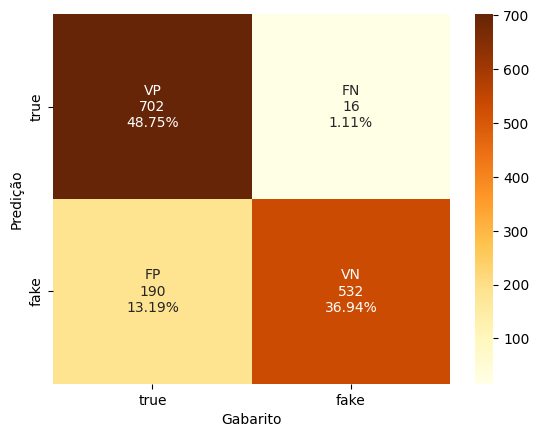

In [33]:
display_confusion_matrix(bert_model, bert_tokenizer,testdata)

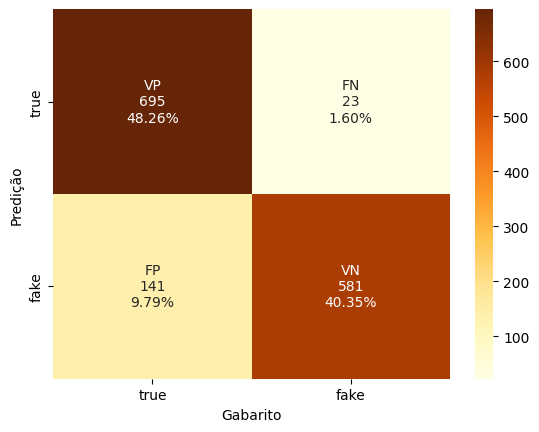

In [34]:
display_confusion_matrix(distil_model, distil_tokenizer,testdata)

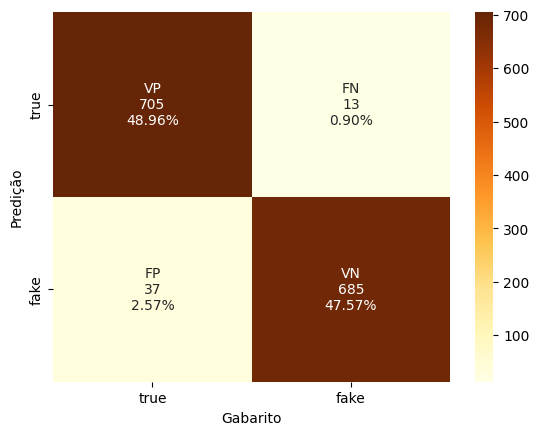

In [35]:
display_confusion_matrix(bertimbau_model, bertimbau_tokenizer,testdata)